# 0. Configuration

In [2]:
# links to shared data MovieLens
# source on kaggle: https://www.kaggle.com/code/quangnhatbui/movie-recommender/data
RATINGS_SMALL_URL = 'https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link'
MOVIES_METADATA_URL = 'https://drive.google.com/file/d/19g6-apYbZb5D-wRj4L7aYKhxS-fDM4Fb/view?usp=share_link'

# 1. Modules and functions

In [3]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import pandas as pd

from itertools import islice, cycle, product

from lightfm.data import Dataset
from lightfm import LightFM

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')


C:\Users\elena\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## 1. 1. Helper functions to avoid copy paste

In [4]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

# 2. Main

## 2.1. Load Data

`interactions` dataset shows list of movies that users watched, along with given ratings:

In [5]:
# interactions data
interactions = read_csv_from_gdrive(RATINGS_SMALL_URL)
interactions.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


`movies_metadata` dataset shows the list of movies existing on OKKO platform:

In [6]:
# information about films etc
movies_metadata = read_csv_from_gdrive(MOVIES_METADATA_URL)
movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [7]:
movies_metadata['id'] = movies_metadata['id'].astype(str)
interactions['movieId'] = interactions['movieId'].astype(str)

In [8]:
# leave only those films that intersect with each other
interactions_filtered = interactions.loc[interactions['movieId'].isin(movies_metadata['id'])]
print(interactions.shape, interactions_filtered.shape)

(100004, 4) (44989, 4)


In [9]:
interactions_filtered  = interactions_filtered.head(10000)

## 2.2 Data preparation using LightFM Dataset

To use this class we need the in the following format:
- userId
- movieId
- user_features - user feature names
- item_features - item feature names

It has several methods:
- build_interactions - definition of user / item interactions matrix using iterators on top of tuples:
1. (userId, movieId);
2. (userId, movieId, weight / rating)
- build_user_features/build_item_features - defition of user/item features using iterators on top of tuples:
1. (userId, [user_feature_name1, user_feature_name2, ...]);
2. (userId, {user_feature_name1: weight});
3. The same goes for item features


In [10]:
# init class
dataset = Dataset()

In [11]:
# fit tuple of user and movie interactions
dataset.fit(interactions['userId'].unique(), interactions['movieId'].unique())

We do not have users data in MovieLens dataset so let's skip part features generation

In [12]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
# lightfm_mapping

In [13]:
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  671
user features mapper length -  671
movies mapper length -  9066
Users movie features mapper length -  9066


As we do not have user / movie features their length are the same as userId and movieId

In [14]:
# here we create inverted mappers to check recommendations later
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [15]:
lightfm_mapping

{'users_mapping': {1: 0,
  2: 1,
  3: 2,
  4: 3,
  5: 4,
  6: 5,
  7: 6,
  8: 7,
  9: 8,
  10: 9,
  11: 10,
  12: 11,
  13: 12,
  14: 13,
  15: 14,
  16: 15,
  17: 16,
  18: 17,
  19: 18,
  20: 19,
  21: 20,
  22: 21,
  23: 22,
  24: 23,
  25: 24,
  26: 25,
  27: 26,
  28: 27,
  29: 28,
  30: 29,
  31: 30,
  32: 31,
  33: 32,
  34: 33,
  35: 34,
  36: 35,
  37: 36,
  38: 37,
  39: 38,
  40: 39,
  41: 40,
  42: 41,
  43: 42,
  44: 43,
  45: 44,
  46: 45,
  47: 46,
  48: 47,
  49: 48,
  50: 49,
  51: 50,
  52: 51,
  53: 52,
  54: 53,
  55: 54,
  56: 55,
  57: 56,
  58: 57,
  59: 58,
  60: 59,
  61: 60,
  62: 61,
  63: 62,
  64: 63,
  65: 64,
  66: 65,
  67: 66,
  68: 67,
  69: 68,
  70: 69,
  71: 70,
  72: 71,
  73: 72,
  74: 73,
  75: 74,
  76: 75,
  77: 76,
  78: 77,
  79: 78,
  80: 79,
  81: 80,
  82: 81,
  83: 82,
  84: 83,
  85: 84,
  86: 85,
  87: 86,
  88: 87,
  89: 88,
  90: 89,
  91: 90,
  92: 91,
  93: 92,
  94: 93,
  95: 94,
  96: 95,
  97: 96,
  98: 97,
  99: 98,
  100: 99,
 

As we mentioned earlier, we need to create iterators

In [14]:
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    '''
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

<AxesSubplot:>

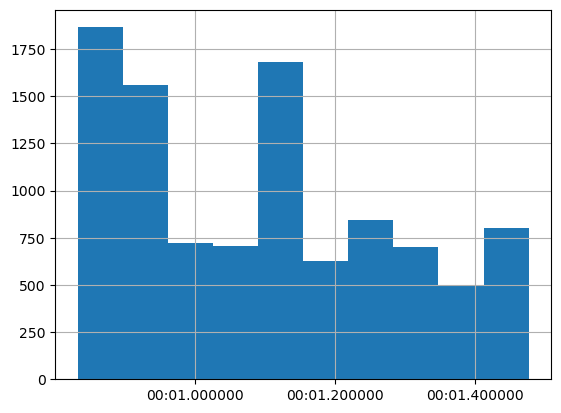

In [15]:
pd.to_datetime(interactions_filtered['timestamp']).hist()

In [16]:
#let's split the data into train and test sets
TRAIN_MAX_DATE = np.quantile([interactions_filtered['timestamp']], 0.75) # define last date to include in train set
TEST_MAX_DATE = interactions_filtered['timestamp'].max()


df=interactions_filtered
interactions_filtered['timestamp'] = pd.to_datetime(interactions_filtered['timestamp'])

train_set = df.loc[df['timestamp'] <= pd.Timestamp(TRAIN_MAX_DATE)].reset_index(drop = True)
test_set = df.loc[(df['timestamp'] > pd.Timestamp(TRAIN_MAX_DATE)) \
                  & (df['timestamp'] <= pd.Timestamp(TEST_MAX_DATE))].reset_index(drop = True)

In [17]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(train_set[['userId', 'movieId']]))
test_mat, test_mat_weights = dataset.build_interactions(df_to_tuple_iterator(test_set[['userId', 'movieId']]))

In [18]:
train_mat

<671x9066 sparse matrix of type '<class 'numpy.int32'>'
	with 7500 stored elements in COOrdinate format>

In [19]:
train_mat_weights

<671x9066 sparse matrix of type '<class 'numpy.float32'>'
	with 7500 stored elements in COOrdinate format>

In [20]:
test_mat

<671x9066 sparse matrix of type '<class 'numpy.int32'>'
	with 2500 stored elements in COOrdinate format>

In [21]:
test_mat_weights

<671x9066 sparse matrix of type '<class 'numpy.float32'>'
	with 2500 stored elements in COOrdinate format>

## 2.3. Model Training & Evaluation

### 2.3.1. Train Model

In [22]:
# set params
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [23]:
# init model
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    learning_rate = LEARNING_RATE,
    loss = LOSS,
    max_sampled = MAX_SAMPLED,
    random_state = RANDOM_STATE
    )

In [ ]:
# execute training
for _ in tqdm_notebook(range(EPOCHS), total = EPOCHS):
    lfm_model.fit_partial(
        train_mat, 
        num_threads = 4
    )

  0%|          | 0/20 [00:00<?, ?it/s]

### 2.3.2. Evaluate the Model

In [38]:
# let's make sense-check
top_N = 10
user_id = interactions['userId'][0]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 1, row number in matrix - 0


In [39]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

9066

In [40]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

(array([-1.5072781 , -1.5754961 , -1.6452368 , ..., -0.54395187,
        -1.7159282 , -1.6124845 ], dtype=float32),
 (9066,))

In [41]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([143,  72,  49,  92, 113, 110, 119, 505,  79,  99])

In [42]:
pred[top_cols]

array([2.422565 , 2.2984023, 2.2975855, 2.2897859, 2.2075982, 2.2017121,
       2.2014942, 2.1033106, 2.096772 , 2.0668266], dtype=float32)

In [43]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata['id'], movies_metadata['original_title']))

In [44]:
recs = pd.DataFrame({'col_id': top_cols})
recs['movieId'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get).astype(str)
recs['title'] = recs['movieId'].map(item_name_mapper)
recs

,col_id,movieId,title
0,143,260,The 39 Steps
1,72,480,Monsoon Wedding
2,49,296,Terminator 3: Rise of the Machines
3,92,593,Солярис
4,113,2028,Say Anything...
5,110,1580,Rope
6,119,2762,Young and Innocent
7,505,608,Men in Black II
8,79,527,Once Were Warriors
9,99,318,The Million Dollar Hotel


### 2.3.3. Wrapping up the rec pipeline into function

In [ ]:
def lfm_recommend(model, 
                  lightfm_mapping,
                  item_name_mapper,
                  movies_inv_mapping,
                  all_cols,
                  num_threads:int
                  ):
    rekkos = pd.DataFrame(data = [], columns=['userId', 'movieId', 'title'])
    for key, value in lightfm_mapping['users_mapping'].items():
        
        pred= predict(
        value,
        all_cols,
        num_threads = 4)
        
        top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
        
        recs = pd.DataFrame({'col_id': top_cols})
        pred['userId'] = [key for x in np.ones(len(recs))]
        recs['movieId'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get).astype(str)
        recs['title'] = recs['movieId'].map(item_name_mapper)
        recs['movieId'] = recs['inv_movie_id'].map(movies_inv_mapping.get)
        recs['title'] = recs['movieId'].map(movie_name_mapper)
        
        rekkos = pd.concat([rekkos,recs[['userId', 'movieId','title']]]).reset_index(drop=True)
        
    return rekkos


In [ ]:
final_rekkomendations = lfm_recommend(lfm_model, lightfm_mapping, item_name_mapper, movies_inv_mapping,all_cols, 4)

### 2.3.4. NDCG@10 calculation

In [16]:
def compute_gain(y_value: float, gain_scheme: str) -> float:
    
    gain = {'exp2': 2 ** y_value - 1,
            'const': y_value}

    return float(gain[gain_scheme])

In [17]:
def dcg(y_true: np.array, y_pred: np.array, gain_scheme: str) -> float:
    
    dcg = 0
    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]

    for idx, val in enumerate(y_true_sorted, 1):
        gain = compute_gain(val, gain_scheme)
        dcg += gain / log2(idx + 1)
        
    return dcg

In [18]:
def ndcg(y_true: np.array, ys_pred: np.array, gain_scheme: str = 'const') -> float:
    
    # pred dcg then we calc the same to find max possible
    preds_dcg = dcg(y_true, ys_pred, gain_scheme)
    max_possible_dcg = dcg(y_true, y_true, gain_scheme)

    return preds_dcg / max_possible_dcg

In [19]:
#let's firstly define relevance score for our predictions based on users' interactions
final_rekkomendations['rank'] = final_rekkomendations.groupby('userId')['userId'].rank(method = 'first', ascending=True)
interactions = interactions.sort_values(by=['userId', 'timestamp'])
interactions = interactions.groupby('userId').head(10)
interactions['rank_true'] = interactions.groupby('userId')['timestamp'].rank(method = 'first', ascending=False)

NameError: name 'final_rekkomendations' is not defined

In [ ]:
final_rekkomendations['userId'] = pd.to_numeric(final_rekkomendations['userId'])
final_rekkomendations['movieId'] = pd.to_numeric(final_rekkomendations['movieId'])

In [ ]:
interactions['userId'] = pd.to_numeric(interactions['userId'])
interactions['movieId'] = pd.to_numeric(interactions['movieId'])

In [ ]:
final_rekkomendations = final_rekkomendations.merge(interactions[['userId','movieId','rank_true']], on=['userId', 'movieId'], how='left')

In [ ]:
#filling the empty movies' ids
final_rekkomendations.rank_true = final_rekkomendations.rank_true.fillna(1)

In [ ]:
def metrics_calc(dataset, USER_COL):
    rekko_metrics = pd.DataFrame(data=[], columns=['userId', 'ndcg'])
    final_rekkomendations['rank_true'] = final_rekkomendations['rank_true'].astype('int')
    final_rekkomendations['rank'] = final_rekkomendations['rank'].astype('int')
    for key in users_mapping.keys():
        y_pred = np.array(final_rekkomendations[final_rekkomendations['userId'] == key]['rank'].astype('int').to_list())
        y_true = np.array(final_rekkomendations[final_rekkomendations['userId'] == key]['rank_true'].astype('int').to_list())
        ndcg_metric = ndcg(y_true, y_pred, 'exp2')
        rekko_metrics.loc[key] =  [key, ndcg_metric]
    return rekko_metrics

In [ ]:
USER_COL = 'userId'

In [ ]:
metrics_calc(final_rekkomendations, USER_COL)

# TODO
- Make train/test split -- train the model appropiately and predict on test set;
- Wrap up in function recommendations - lfm_recommend();
- Calculate `NDCG@10` on test set